In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
import torch.nn as nn
import torch.nn.functional as F
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from langdetect import detect
import json
import re
from collections import Counter, defaultdict
import string
from scipy import stats

In [131]:
#Cleaning out the original test and train datasets 
def langFilter(file,type:str):
    num = 0
    with open(f"hotel_review_en_{type}.JSON", "w") as out_file:
        with open(file,"r") as in_file:
            lines = in_file.readlines()
            for line in lines:
                num += 1
                # if num%100==0: print(num)
                json_line = json.loads(line)
                try:
                    lang = detect(json_line["text"])
                    if lang == "en":
                        out_file.write(line)
                except:
                    print("exception")
                    pass

#uncomment to generate JSON train and test sets of only english texts
# langFilter("hotel_reviews_train.JSON","train")
# langFilter("hotel_reviews_test.JSON","test")

In [132]:
train_data = pd.read_json('hotel_review_en_train.JSON', lines=True)
test_data = pd.read_json('hotel_review_en_test.JSON', lines=True)
train_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False


In [133]:
test_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“I was SO surprised! I WILL return!”,My husband and I just celebrated our 25th wedd...,"{'username': 'shooflyfarm', 'num_cities': 15, ...",November 2011,1783324,1,2011-11-26,121063682,False
1,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“A Mother/Daughter vacation”,I could not leave a bad comment on any part of...,"{'username': 'bestmpm', 'num_reviews': 1, 'id'...",August 2011,88458,0,2011-08-10,116545869,False
2,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Good Choice for Pre-cruise”,I spent one night at this hotel prior to a cru...,"{'username': 'Conner2dood', 'num_cities': 20, ...",November 2010,82868,0,2010-12-06,89196759,False
3,"{'cleanliness': 5.0, 'sleep_quality': 5.0, 'ov...",“Unsung Hero”,"For the past year and a half, my daughter has ...","{'username': 'LeviK', 'num_reviews': 2, 'num_c...",July 2011,98979,0,2011-07-28,115879719,False
4,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Great Value for a King, Queen, and Princesses.”","Great Value for a King, Queen, and Princesses....","{'username': 'thomrho', 'num_cities': 13, 'num...",March 2007,112273,8,2007-03-21,7198417,False


In [134]:
train_data.columns

Index(['ratings', 'title', 'text', 'author', 'date_stayed', 'offering_id',
       'num_helpful_votes', 'date', 'id', 'via_mobile'],
      dtype='object')

In [135]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23999 entries, 0 to 23998
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ratings            23999 non-null  object        
 1   title              23999 non-null  object        
 2   text               23999 non-null  object        
 3   author             23999 non-null  object        
 4   date_stayed        23049 non-null  object        
 5   offering_id        23999 non-null  int64         
 6   num_helpful_votes  23999 non-null  int64         
 7   date               23999 non-null  datetime64[ns]
 8   id                 23999 non-null  int64         
 9   via_mobile         23999 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(3), object(5)
memory usage: 1.7+ MB


In [136]:
train_data.isna().sum()

ratings                0
title                  0
text                   0
author                 0
date_stayed          950
offering_id            0
num_helpful_votes      0
date                   0
id                     0
via_mobile             0
dtype: int64

In [137]:
train_data['id'].duplicated().sum()

0

In [138]:
train_data['ratings'][0]

{'service': 1.0,
 'cleanliness': 2.0,
 'overall': 1.0,
 'value': 1.0,
 'location': 3.0,
 'sleep_quality': 2.0,
 'rooms': 1.0}

In [139]:
unique_cols = defaultdict(int)

for i in range(len(train_data)):
    for n in train_data['ratings'][i].keys():
        unique_cols[n] += 1

unique_cols

defaultdict(int,
            {'service': 21549,
             'cleanliness': 21544,
             'overall': 23999,
             'value': 21546,
             'location': 18982,
             'sleep_quality': 14184,
             'rooms': 19999,
             'check_in_front_desk': 2909,
             'business_service_(e_g_internet_access)': 1959})

In [140]:
def average_ratings(data):
    ratings = defaultdict(list)
    for i in range(len(data)):
        rat = train_data['ratings'][i]
        for n in rat:
            ratings[n].append(rat[n])
    
    avg_metrics = defaultdict(int)
    for n in ratings:
        avg_metrics[n] = np.round(np.array(ratings[n]).mean(),3)
    
    return avg_metrics

averaged_ratings_of_reviews = average_ratings(train_data)

for quality, rating in averaged_ratings_of_reviews.items():
    print(f'{quality}: {rating}')


service: 4.102
cleanliness: 4.23
overall: 3.943
value: 3.918
location: 4.413
sleep_quality: 4.146
rooms: 3.943
check_in_front_desk: 3.945
business_service_(e_g_internet_access): 3.662


In [141]:
print(train_data['ratings'])

0        {'service': 1.0, 'cleanliness': 2.0, 'overall'...
1        {'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...
2        {'service': 4.0, 'cleanliness': 5.0, 'overall'...
3        {'service': 3.0, 'cleanliness': 2.0, 'overall'...
4                                         {'overall': 1.0}
                               ...                        
23994    {'service': 3.0, 'cleanliness': 4.0, 'overall'...
23995    {'service': 3.0, 'cleanliness': 3.0, 'overall'...
23996    {'service': 4.0, 'cleanliness': 4.0, 'overall'...
23997    {'cleanliness': 5.0, 'sleep_quality': 4.0, 'ov...
23998    {'service': 5.0, 'cleanliness': 5.0, 'overall'...
Name: ratings, Length: 23999, dtype: object


In [142]:
print(train_data['ratings'][0])


{'service': 1.0, 'cleanliness': 2.0, 'overall': 1.0, 'value': 1.0, 'location': 3.0, 'sleep_quality': 2.0, 'rooms': 1.0}


In [143]:
json_cols = ['ratings']

normalized_cols = pd.json_normalize(train_data['ratings'])
train_data_new = train_data.join(normalized_cols)
train_data_new = train_data_new.drop(json_cols, axis=1)

In [144]:
unique_cols

defaultdict(int,
            {'service': 21549,
             'cleanliness': 21544,
             'overall': 23999,
             'value': 21546,
             'location': 18982,
             'sleep_quality': 14184,
             'rooms': 19999,
             'check_in_front_desk': 2909,
             'business_service_(e_g_internet_access)': 1959})

In [145]:
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access)
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,NaN,NaN
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,NaN,NaN
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,NaN,NaN
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
train_data_new.isna().sum()

title                                         0
text                                          0
author                                        0
date_stayed                                 950
offering_id                                   0
num_helpful_votes                             0
date                                          0
id                                            0
via_mobile                                    0
service                                    2450
cleanliness                                2455
overall                                       0
value                                      2453
location                                   5017
sleep_quality                              9815
rooms                                      4000
check_in_front_desk                       21090
business_service_(e_g_internet_access)    22040
dtype: int64

In [147]:
train_data_new = train_data_new.drop(['business_service_(e_g_internet_access)', 'check_in_front_desk'], axis=1)
train_data_new.isna().sum()

title                   0
text                    0
author                  0
date_stayed           950
offering_id             0
num_helpful_votes       0
date                    0
id                      0
via_mobile              0
service              2450
cleanliness          2455
overall                 0
value                2453
location             5017
sleep_quality        9815
rooms                4000
dtype: int64

<Axes: >

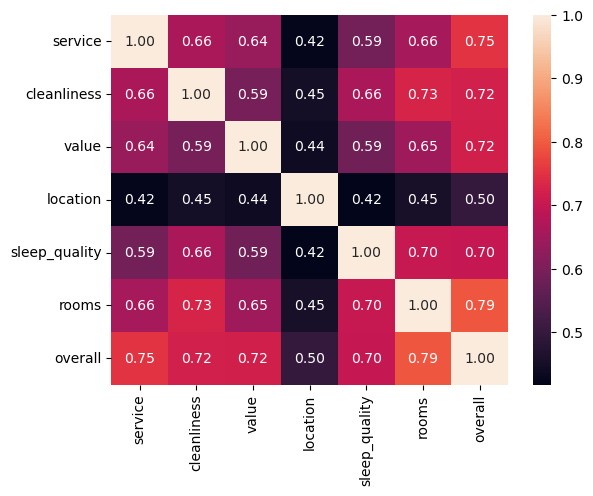

In [148]:
import seaborn as sns
cols = ['service','cleanliness','value','location','sleep_quality','rooms','overall']
corr = train_data_new[cols].corr(method='spearman')
sns.heatmap(corr, annot=True, fmt=".2f")

In [149]:
spearman_overall = (
    train_data_new[cols].corr(method="spearman")['overall']
    .drop('overall')
    .sort_values(ascending=False)
)
print(spearman_overall)

rooms            0.793961
service          0.750456
cleanliness      0.721267
value            0.719540
sleep_quality    0.700825
location         0.498392
Name: overall, dtype: float64


In [150]:
train_data_new['missing_sq'] = train_data_new['sleep_quality'].isna().astype(int)
train_data_new['missing_sq']

0        0
1        0
2        0
3        0
4        1
        ..
23994    0
23995    0
23996    1
23997    0
23998    1
Name: missing_sq, Length: 23999, dtype: int64

<Axes: xlabel='missing_sq', ylabel='overall'>

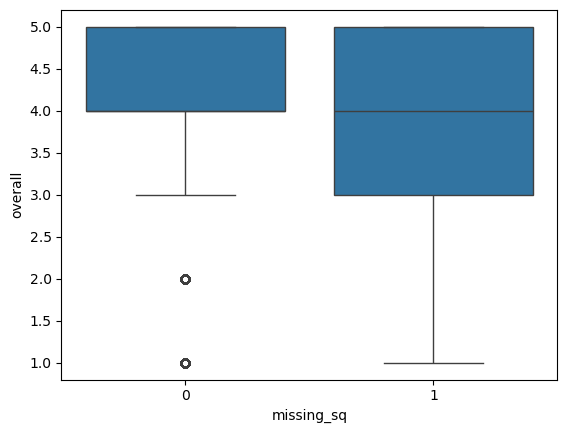

In [151]:
sns.boxplot(x='missing_sq', y='overall', data=train_data_new)

In [152]:
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,0
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,0
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,0
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,0
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1


In [153]:
train_data_new['author'][2]

{'username': 'Moonstonemoclips',
 'num_cities': 31,
 'num_helpful_votes': 27,
 'num_reviews': 48,
 'num_type_reviews': 32,
 'id': 'F3D0CF371B788300E73A1413B2DABB4B',
 'location': 'Kirkland'}

In [154]:
author_keys = defaultdict(int)

for n in train_data_new['author']:
    for j in n:
        author_keys[j] += 1

author_keys

defaultdict(int,
            {'username': 23999,
             'num_reviews': 22918,
             'id': 23999,
             'location': 23999,
             'num_cities': 17538,
             'num_helpful_votes': 18864,
             'num_type_reviews': 14629})

In [155]:
def most_common_author_features(column):
    unique_username = Counter()
    for n in train_data_new['author']:
        if column not in n:
            continue
        name = n[column]
        unique_username[name] += 1 if name in unique_username else 0

    return unique_username.most_common(10)

most_common_author_features('username')

[('', 1077),
 ('David M', 5),
 ('John S', 4),
 ('David C', 4),
 ('David P', 3),
 ('Mike R', 3),
 ('DoesNotGetOutMuch', 3),
 ('Linda D', 3),
 ('brmusicman', 3),
 ('Christine H', 3)]

In [156]:
most_common_author_features('location')

[('', 2183),
 ('New York City, New York', 273),
 ('London, United Kingdom', 236),
 ('Chicago, Illinois', 219),
 ('London', 201),
 ('Houston, Texas', 186),
 ('Los Angeles, California', 185),
 ('Washington DC, District of Columbia', 180),
 ('Boston, Massachusetts', 148),
 ('Toronto, Canada', 146)]

In [157]:
david_cities = []
for n in train_data_new['author']:
    if n['username'] == 'David M':
        david_cities.append(n['location'])

david_cities

['London, United Kingdom',
 'New Bern, North Carolina',
 'Quad Cities, IA',
 'Amarillo',
 'Ukiah, CA',
 'Omaha, Nebraska']

In [158]:
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,0
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,0
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,0
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,0
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1


In [159]:
train_data_new['date_stayed'] = pd.to_datetime(
    train_data_new['date_stayed'].str.strip(),
    format = "%B %Y",
    errors = 'coerce'
)

train_data_new["date_stayed"] = train_data_new["date_stayed"].dt.strftime("%Y-%m")
train_data_new.head()

,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,service,cleanliness,overall,value,location,sleep_quality,rooms,missing_sq
0,“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",2012-09,80138,0,2012-09-19,140716137,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,0
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",2011-06,240151,1,2011-06-27,114807323,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,0
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",2010-10,80793,0,2010-10-25,84805430,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,0
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",2012-06,111418,1,2012-06-28,132971117,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,0
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",2012-01,671150,3,2012-02-04,124104157,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1


In [160]:
mobile = train_data_new[train_data_new['via_mobile'] == True]
not_mobile = train_data_new[train_data_new['via_mobile'] == False]

percentage_from_phone = round(len(mobile)/len(train_data_new),4)
percentage_from_phone

0.0564

In [161]:
percentage_no_phone = round(len(not_mobile)/len(train_data_new),4)
percentage_no_phone

0.9436

In [162]:
assert percentage_no_phone + percentage_from_phone == 1.00, 'issue with calcuation of percentages'

In [163]:
mobile['overall'].mean()

3.926090169992609

In [164]:
not_mobile['overall'].mean()

3.9445376666961054

In [165]:
phone_lengths = train_data_new[train_data_new['via_mobile'] == True]['text'].str.len()
no_phone_lengths = train_data_new[train_data_new['via_mobile'] == False]['text'].str.len()

print(f"mean review length for reviews posted using phone: {round(phone_lengths.mean(),4)} characters")
print(f"mean review length for reviews posted not using phone: {round(no_phone_lengths.mean(),4)} characters")

mean review length for reviews posted using phone: 533.0281 characters
mean review length for reviews posted not using phone: 847.9381 characters
